In [ ]:
#pip install torch

In [ ]:
import torch as th
import numpy as np
import random
from tqdm import tqdm
#сделаем инициализацию random seed, 
#чтобы наши эксперименты были воспроизводимы

random.seed(0)
np.random.seed(0)
th.manual_seed(0)
th.cuda.manual_seed(0)
th.backends.cudnn.deterministic=True

In [ ]:
#скачивание датасета для классификации изображений
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download = True, train = True)
MNIST_test = torchvision.datasets.MNIST('./', download = True, train = False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
#посмотрим какой у данных тип
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [ ]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем сразу данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

In [ ]:
#посмотрим на расзмерность датасетов
X_train.shape, X_test.shape
#это очень маленькие картинки, именно поэтому мы можем использовать
#полносвязную нейронную сеть для такой задачи, а не сверточные сети

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [ ]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

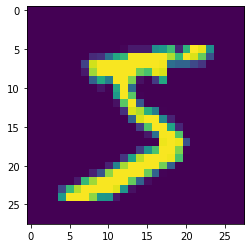

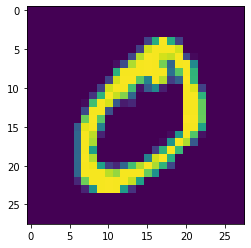

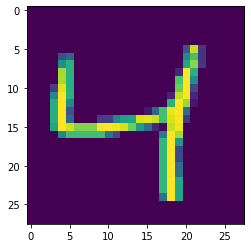

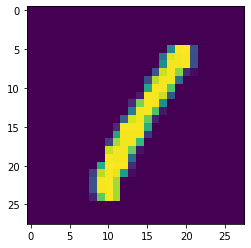

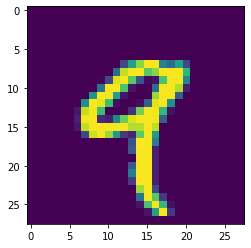

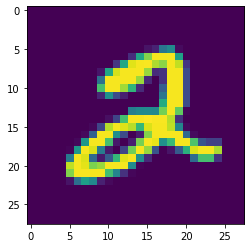

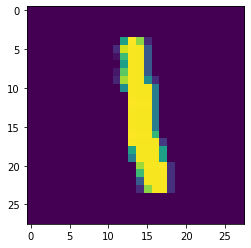

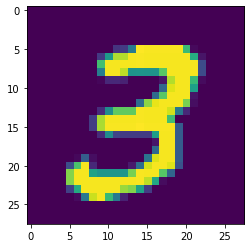

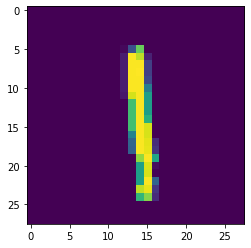

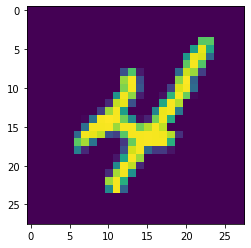

tensor(3)


In [ ]:
#посмотрим на картинки
import matplotlib.pyplot as plt
for i in range(0, 10):
  plt.imshow(X_train[i, :, :])
  plt.show()
print(y_train[7])

In [ ]:
#у нас трезмерный тензор, мы хотим двумерный тензор, 
#чтобы первая рамерность сохранилась, то есть 60000 картинок
#вместо 28 и 28 будет 764 пикселя

X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

print(X_train)


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
#Создание сети
# на выходе у нас числа от 0 до 9
class MNISTnet(th.nn.Module):
  def __init__(self):
    super (MNISTnet, self).__init__()
    self.fc1 = th.nn.Linear(784, 128)
    self.fc2 = th.nn.Linear(128, 64)
    self.fc3 = th.nn.Linear(64, 10) 
    self.act = th.nn.ReLU()  
    self.sm = th.nn.Softmax(dim = 1)

  def forward(self, x):
    x = self.act(self.fc1(x))
    x = self.act(self.fc2(x))
    x = self.act(self.fc3(x))
    return x

  def predict(self,x):
    x = self.forward(x)
    x = x.to(device)
    print(x)
    x = self.sm(x)
    return x
net = MNISTnet()

In [ ]:
''' есть ли видеокарта?'''
th.cuda.is_available()

True

In [ ]:
'''смотрим, занята ли карта какими либо вычислениями'''
!nvidia-smi

Sat Mar  4 21:54:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    26W /  70W |      3MiB / 15360MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
""" теперь нужно переложить вычисления на видеокарту"""

device = th.device('cuda:0' if th.cuda.is_available() else 'cpu')
net = net.to(device)

In [ ]:
loss = th.nn.CrossEntropyLoss()
optimizer = th.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
batch_size = 50
epochs = 100 

X_test = X_test.to(device)
y_test = y_test.to(device)

X_train = X_train.to(device)
y_train = y_train.to(device)
#fig = plt.figure(figsize=(30, 10))
train_losses = []
epoch_counter = []
test_losses = []

for epoch in tqdm(range(epochs)):
  order = np.random.permutation(len(X_train))
  for start_index in range (0,len(X_train), batch_size):
    optimizer.zero_grad()
    batch_index = order[start_index:start_index+batch_size]

    X_batch = X_train[batch_index]
    y_batch = y_train[batch_index]
    preds = net.forward(X_batch)
    loss_val = loss(preds, y_batch)
    loss_val.backward()

    optimizer.step()
  if epoch % 2 == 0:
    train_losses.append(loss_val)
    test_preds = net.forward(X_test)
    loss_pred = loss(test_preds, y_test) 
    test_losses.append(loss_pred) 
    epoch_counter.append(epoch)
    test_preds = test_preds.argmax(dim=1)
  #


100%|██████████| 100/100 [03:30<00:00,  2.10s/it]


In [ ]:
def pred_test(i): 
  img = X_test[i].view(1, 784) 
  with th.no_grad():
    logps = net.predict(img)
  ps = th.exp(logps)
  probab = list(ps.cpu().numpy()[0])
  print("Predicted Digit =", probab.index(max(probab)))
  print("Current value =", y_test.cpu().numpy()[i])
  plt.subplots(figsize=(6,9))
  plt.imshow(X_test.cpu()[i].resize(1, 28, 28).numpy().squeeze())
  plt.show()

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 15.8363,
          0.0000,  3.2702]], device='cuda:0')
Predicted Digit = 7
Current value = 7


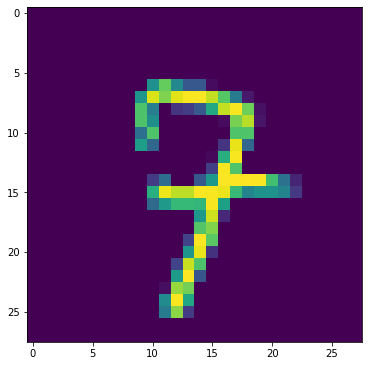

In [ ]:
pred_test(550)

In [ ]:
preds = net.predict(X_test)
true_vals, all_vals = 0, 0
for i in range(10000):
  probab = list(preds.cpu().detach().numpy()[i])
  if probab.index(max(probab)) == y_test.cpu().numpy()[i]:
    true_vals += 1
  else: 
    print(i, end=" ")
  all_vals += 1

print("\nNumber Of Images Tested =", all_vals)
print("Model Accuracy =", (true_vals/all_vals))

tensor([[  0.0000,   0.0000,   0.0000,  ...,  64.5317,   0.0000,   0.0000],
        [  0.0000,   0.0000, 237.0405,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,  87.6107,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],
       device='cuda:0', grad_fn=<ReluBackward0>)
8 61 149 151 247 290 321 359 445 447 449 495 551 582 610 619 659 720 726 877 882 883 924 938 947 956 1014 1039 1044 1101 1112 1156 1181 1182 1224 1226 1232 1247 1260 1289 1299 1319 1328 1414 1433 1494 1522 1530 1549 1553 1600 1609 1620 1681 1709 1717 1754 1828 1878 1901 1903 1941 1952 1982 2004 2016 2070 2093 2098 2109 2118 2129 2130 2135 2182 2185 2189 2266 2272 2293 2369 2387 2414 2488 2560 2573 2597 2607 2648 2654 2720 2721 2730 2769 2771 2921 2927 2930 2939 2952 2953 2995 

In [ ]:
 plt.plot(x.numpy(), y.numpy(), 'o', label = 'Исходные данные')
  plt.plot(x.numpy(), y_pred.data.numpy(),'o',c='r', label = 'Предсказание')
  plt.legend()
  plt.xlabel('x')
  plt.ylabel('y')

###Задание


1.   Дописать код после фразы Ваш_Код_Здесь.
2.   Поэкспериментировать с гиперпараметрами нейронной сети, чтобы добиться более высокой точности классификации.
4.   Построить на одном графике loss для тестовой выборки и для обучающей.
5.   Ведет ли увеличение количества эпох (40 эпох -> 200 эпох) к улучшению метрик на валидации?
6.   Замерьте время вычисления 100 эпох на CPU и на GPU.
7.   Показать результат работы модели с использованием функции predict.
